# This software tutorial is based on pwg-tutorials
https://github.com/simonsobs/pwg-tutorials<br>
ipython notebook<br>
https://github.com/simonsobs/pwg-tutorials/blob/master/sotodlib_G3tSMuRF_Tutorial_20220201.ipynb

## Software Packages 

#### [`spt3g-software`](https://github.com/CMB-S4/spt3g_software)
Defines the SO saved file format and software for interfacing with the files. (Also, a lot of other things SO isn't using at the moment). 

#### [`so3g`](https://github.com/simonsobs/so3g)
SO specific extensions to SPT3G-software. Contains a combination of DAQ and TOD2Maps software. Anything built in C++ is in this repository.

Documentation is on readthedocs here: https://so3g.readthedocs.io/en/latest/

#### [`sotodlib`](https://github.com/simonsobs/sotodlib)
Data processing for the SO time ordered data software stack. Includes simulation setups, data loading, and processing. At this point this is a completely python based library.

Documentation is on readthedocs here: https://sotodlib.readthedocs.io/en/latest/

## Import libraries
Import SO related libraries like so3g, sotodlib<br>
If you see any error after this, check the name of kernel. The kernel name must be soenv_20220401 at UTokyo workstation.

In [1]:
%matplotlib inline

import numpy as np
import datetime as dt
import time as tm
import matplotlib.pyplot as plt

import sqlalchemy as db

from so3g.proj import Ranges, RangesMatrix

import sotodlib.core as core
from sotodlib.io.load_smurf import (G3tSmurf, Observations, TuneSets, \
                                    Channels, Files, ChanAssignments)
from sotodlib.io.load_smurf import load_file

import sotodlib.tod_ops.filters as filters
from sotodlib.tod_ops import fourier_filter, rfft, detrend_tod

from sotodlib.core import FlagManager
import sotodlib.flags as flags

## File System


#### On `simons1`, each lab has a base directory of `/mnt/so1/data/<lab-location>/`

Within that base directory we have all configured our Smurf systems / OCS such that the file system is:

* `timestreams/`
    * `<5 digit ctime>/`
        * `<stream-id>/` (stream id generally takes the form of crateXslotY)
            * `<10 digit ctime>_XYZ.g3` -- All the written out g3 files
* `smurf/`
    * `<5 digit ctime>/`
        * `<stream-id>/` (stream id generally takes the form of crateXslotY)
            * `<10 digit ctime>_smurf_action/` 
                * `outputs/` -- outputs from `pysmurf`/`sodetlib` during action
                * `plots/` -- plots made by `pysmurf`/`sodetlib` during action
* `hk/`
    * `<5 digit ctime>/`
        * `<10 digit ctime>.g3` -- output housekeeping data
        
    


## `G3tSmurf` Databasing

The `G3tSmurf` system uses the SO file system and save patterns to build a set of databases needed to locate data. Updating the databases requires running a few pre-defined commands on an existing database (or to build a new one). From scratch, these databases currently take between minutes to ~hour to build and will scale as we get more data. **Katie recommends that each lab have their own person responsible for building a shared database and that that person sets up a cronjob to update these automatically. [There are docs and a specific script for this](https://sotodlib.readthedocs.io/en/latest/g3tsmurf.html#database-creation-and-upkeep).**

The Databasing and their queries are currently built using `SQLAlchemy`. This is a nice python way of connecting to an sqlite database, both for building databases and running queries. There are examples of queries in the cells below but for a more comprehensive guide look for SQLAlchemy Tutorials such as: https://docs.sqlalchemy.org/en/14/orm/tutorial.html#querying

### Databases

A more up-to-date description of the databases maybe [in the docs]( https://sotodlib.readthedocs.io/en/latest/g3tsmurf.html#module-sotodlib.io.g3tsmurf_db).

#### Observations

These are made every time specific SMuRF actions are found in the `smurf/` archive. We are currently indexing:  
* take_stream_data
* stream_data_on
* take_noise_psd 
* take_g3_data
* stream_g3_on

This can be expanded as desired

#### TuneSets / Tunes

Tunes: indexes every Tune file. 
TuneSets: indexes every Tune file where the channel assignments have changed

#### Channels

All SMuRF channels we've found in the channel assignments. We make a new set every time there's a new channel assignment

* channel names: `<ctime>_<stream_id>_A_BBB` where `A` is SMuRF band and `BBB` is SMuRF Channel. 
    * ctime is the ctime of the associated channel assignment for that channel. 
* Also tracks: channel, subband, frequency

#### Files
Indexes all .g3 files, whether or not they are part of an observation.

## Connect to G3tSmurf

Create instance of G3tSmurf class<br>
archive_path: directory of timestream(time ordered data)、meta_path: directory of metadata (tuning data etc)、db_path: file name of SQLite database<br>
SMURF.Session(): generate sqlalchemy session<br>
sqlalchemy: sqlite toolkit<br>
https://www.sqlalchemy.org/<br>
SQLAlchemy is the Python SQL toolkit and Object Relational Mapper that gives application developers the full power and flexibility of SQL.

In [2]:
SMURF = G3tSmurf(archive_path= '/homes/kkiuchi/pwg-tutorials/data/timestreams',
                meta_path = '/homes/kkiuchi/pwg-tutorials/data/smurf',
                db_path='/homes/kkiuchi/pwg-tutorials/frames.db')
session = SMURF.Session()

## Querying Databases
#### Search observation
You can find observation using querying sqlite database via SQLAlchemy

In [3]:
## Find the observation which started taking data between 2022/1/28 to 2022/2/1
q = session.query(Observations).filter(Observations.start >= dt.datetime(2022,1,28), 
                                       Observations.start <= dt.datetime(2022,2,1))

print(f'I found {q.count()} observations.')
print(f'The first observation in the query is:\n\t {q[0]}')

print('But sometimes these are out of order, so I will sort by Observation time')
q = q.order_by(Observations.start)
print(f'Now the first observation is:\n\t {q[0]}')


I found 1 observations.
The first observation in the query is:
	 crate1slot4_1643342329: 2022-01-28 03:58:49.308130 -> 2022-01-28 04:08:49.690215 [0:10:00.382085] (None)
But sometimes these are out of order, so I will sort by Observation time
Now the first observation is:
	 crate1slot4_1643342329: 2022-01-28 03:58:49.308130 -> 2022-01-28 04:08:49.690215 [0:10:00.382085] (None)


#### Search tune file
Here we will search Tune file taken before 2022/1/28 and its stream_id is 'crate1slot4'.<br>
Stream id is named using SMuRF crate number and slot number.<br>
Typically one crate has six slots, one slot is able to readout upto 2000 TESes.<br>

In [4]:
## Find the most recent Tuning File relative to a time

time = dt.datetime(2022,1,28)
stream_id = 'crate1slot4'

q = session.query(TuneSets).filter(TuneSets.start <= time, 
                                  TuneSets.stream_id == stream_id)
tune = q.order_by( db.desc(TuneSets.start) ).first()

print(f'The last tune file before {time} for stream_id {stream_id} is {tune.name}')
print(f'This tune file was created on {tune.start}')
print(f'and it can be found at: \n {tune.path}')

The last tune file before 2022-01-28 00:00:00 for stream_id crate1slot4 is 1643327820_tune.npy
This tune file was created on 2022-01-27 23:57:00
and it can be found at: 
 /homes/kkiuchi/pwg-tutorials/data/smurf/16433/crate1slot4/1643327669_setup_notches/outputs/1643327820_tune.npy


#### Search the SMuRF channels with a specific resonator frequency range
In simons observatory, we will use frequency range of 4GHz to 6GHz.<br>
One slot have two modules and each module has 2GHz BW (i.e. 4GHz to 6GHz).<br>
1000 TESes are multiplexed in 2GHz BW.

In [5]:
## Find all the SMuRF channels within a specific resonator frequency range

f_start = 4000
f_stop = 6000
stream_id = 'crate1slot4'

q = session.query(Channels).join(TuneSets, Channels.ca_id!= None).filter(Channels.frequency > f_start, 
                                                 Channels.frequency<= f_stop,
                                                 TuneSets.start >= dt.datetime(2022,1,20),
                                                 TuneSets.stream_id == stream_id)

print(f'I found {q.count()} between {f_start} and {f_stop} MHz')
channels = q.all()
ctimes = np.unique( [ch.chan_assignment.ctime for ch in channels])
print(f'These Channels are from {len(ctimes)} different master assignments')

print('Example Names:')
for i in range(10):
    print( '\t', channels[i].name)

I found 19776 between 4000 and 6000 MHz
These Channels are from 8 different master assignments
Example Names:
	 sch_crate1slot4_1643315726_0_229
	 sch_crate1slot4_1643315726_0_149
	 sch_crate1slot4_1643315726_0_405
	 sch_crate1slot4_1643315726_0_085
	 sch_crate1slot4_1643315726_0_341
	 sch_crate1slot4_1643315726_0_213
	 sch_crate1slot4_1643315726_0_469
	 sch_crate1slot4_1643315726_0_053
	 sch_crate1slot4_1643315726_0_309
	 sch_crate1slot4_1643315726_0_181


## Loading data -- From Files

Loading data from a single .g3 files into an AxisManager should be quite straightforward:

In [6]:
fname = '/homes/kkiuchi/pwg-tutorials/data/timestreams/16433/crate1slot4/1643342329_000.g3'
aman = load_file(fname)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s]


817


Text(0.5, 0, 'Time (s)')

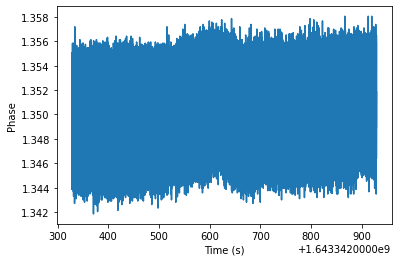

In [7]:
print(len(aman.signal))##number of detectors
plt.figure()
plt.plot( aman.timestamps, aman.signal[433] )
plt.ylabel('Phase')
plt.xlabel('Time (s)')

## Loading Observations

start time, end time and duration
1643342328.5296934 1643342928.5952141 600.0655207633972


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.22it/s]


Text(0.5, 0, 'Time (s)')

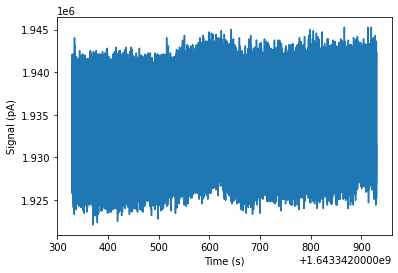

In [8]:
## this observation is an example where we were doing nothing but taking noise
#obs = session.query(Observations).filter(Observations.obs_id == 'crate1slot4_1643342329').one()
obs = session.query(Observations).filter(Observations.obs_id == 'crate1slot4_1643342329').one()
print("start time, end time and duration")
print(aman.timestamps[0], aman.timestamps[-1], aman.timestamps[-1]-aman.timestamps[0])
aman = SMURF.load_data(obs.start, obs.stop)
## Right now this data is returned in phase. 
# Let's change it to pA (yes, we need to add unit control)
phase_to_pA = 9e6/(2*np.pi) #design value of uMUX calculated from mutual inductance of TES and SQUID loop
aman.signal *= phase_to_pA
plt.plot( aman.timestamps, aman.signal[433] )
plt.ylabel('Signal (pA)')
plt.xlabel('Time (s)')

## The AxisManager class
https://sotodlib.readthedocs.io/en/latest/axisman.html<br>


The AxisManager is a container class for numpy arrays and similar structures, that tracks relationships between axes. The object can be made aware, for example, that the 2nd axis of an array called “data” is tied to the 1st axis of an array called “azimuth”; slices / sub-selection operations can be performed on a named on that axis and the entire object will be modified self-consistently.

The data model here is similar to what is provided by the xarray library. However, AxisManager makes it possible to store objects other than numpy ndarrays, if the classes expose a suitable interface.

In [9]:
def print_aman_info(aman):
    if 'timestamps' in aman:
        print("""This observation is {} minutes long.
                 It has {} channels loaded and {} samples""".format(round((aman.timestamps[-1]-aman.timestamps[0])/60.,2),
                                                                              aman.dets.count, aman.samps.count))

    print('This aman AxisManager has {} Axes: '.format(len(aman._axes)))
    for k in aman._axes:
        print('\t{} with {} entries'.format(aman[k].name, aman[k].count ) )

    print('This aman AxisManager has fields : [axes]')
    for k in aman._fields:
        print('\t{} : {}'.format(k, aman._assignments[k]) )
        if type(aman._fields[k]) is core.AxisManager:
            for kk in aman[k]._fields:
                print('\t\t {} : {}'.format(kk, aman[k]._assignments[kk] ))
print_aman_info(aman)

This observation is 10.01 minutes long.
                 It has 817 channels loaded and 120076 samples
This aman AxisManager has 4 Axes: 
	dets with 817 entries
	samps with 120076 entries
	filter_pars with 16 entries
	bias_lines with 16 entries
This aman AxisManager has fields : [axes]
	timestamps : ['samps']
	status : ['filter_pars']
		 dump_frame : []
		 filter_a : ['filter_pars']
		 filter_b : ['filter_pars']
		 filter_gain : []
		 filter_order : []
		 filter_enabled : []
		 downsample_factor : []
		 flux_ramp_rate_hz : []
	signal : ['dets', 'samps']
	ch_info : ['dets']
		 band : ['dets']
		 channel : ['dets']
		 frequency : ['dets']
		 rchannel : ['dets']
		 ruid : ['dets']
	primary : ['samps']
		 AveragingResetBits : ['samps']
		 Counter0 : ['samps']
		 Counter1 : ['samps']
		 Counter2 : ['samps']
		 FluxRampIncrement : ['samps']
		 FluxRampOffset : ['samps']
		 FrameCounter : ['samps']
		 TESRelaySetting : ['samps']
		 UnixTime : ['samps']
	biases : ['bias_lines', 'samps']
	flags

### Channels

The loading function will automatically name the channels in for format discussed above (related to the channel assignment ctime, smurf band, and smurf channel). 

In [10]:
#print( aman.dets.vals )
#print( aman.status.filter_a )
#print( aman.biases[15] )
print ( aman.ch_info.frequency)

[4250.51602254 4173.62197986 4442.11398644 4134.34191432 4365.36801128
 4058.53602452 4269.59598346 4422.48601818 4115.20005445 4192.45996389
 4307.14397969 4461.76398959 4153.74201798 4076.65398021 4259.39596829
 4106.37792912 4336.01200738 4297.51199617 4144.2739635  4221.27201381
 4278.46804838 4048.14196548 4317.7760076  4471.11399255 4394.37397032
 4255.35800061 4408.66600847 4100.87201133 4332.08398237 4293.18400931
 4139.72768645 4427.08000965 4351.37998543 4043.68996973 4466.4719954
 4082.05596375 4236.13199048 4264.05191035 4417.80199246 4110.5059442
 4187.75000186 4456.59600267 4148.91797295 4436.7020072  4053.64400759
 4206.86195431 4475.64399252 4398.49999413 4252.65797229 4328.84998932
 4291.34999762 4444.76800394 4137.74592938 4367.96198978 4060.00799222
 4271.50595875 4424.97400694 4117.96195354 4041.12602596 4195.27399626
 4463.9520071  4079.48596306 4108.52992878 4338.95802917 4300.493957
 4146.21996822 4223.5280334  4280.628021   4435.06999173 4051.04601636
 4204.4839

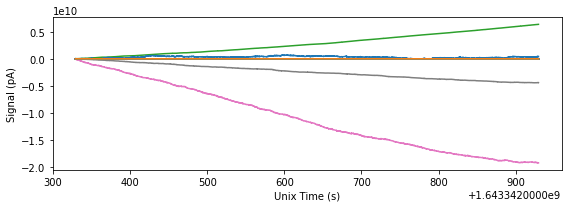

In [11]:
fig = plt.figure(figsize=(8,3))

for i in range(0,aman.dets.count,10):
    #print("detnumber",i)
    plt.plot( aman.timestamps, aman.signal[i] )
plt.ylabel('Signal (pA)')
plt.xlabel('Unix Time (s)')

fig.tight_layout()

## Manipulating AxisManagers

Important AxisManager functions to know about:
* restrict
* wrap
* wrap_new
* move


#### restrict
The nice thing about using `restrict` along the `samps` axis is now *every* item in the AxisManager that has a piece along the `samps` axis is cut in the same way. Ex: It cuts both `aman.timestamps` and `aman.signal` 

In [12]:
## Remove a section from the beginning
print(aman.samps.count)
aman.restrict('samps', (1000,None))
print(aman.samps.count)

120076
119232


#### `wrap()` and `wrap_new()`

Specific Docs: https://sotodlib.readthedocs.io/en/latest/axisman.html#sotodlib.core.AxisManager.wrap

We might want to add new fields to the `aman`, which we can do using the `wrap(name, data, axis_map=None)` function. As an example, let's calculate the mean of the different channels signals (the common mode) and add that to the `aman`.

In [13]:
sig_mean = np.mean( aman.signal, axis = 0)
aman.wrap('sig_mean', sig_mean, [(0,aman.samps)])

AxisManager(timestamps[samps], status*[filter_pars], signal[dets,samps], ch_info*[dets], primary*[samps], biases[bias_lines,samps], flags*[dets,samps], sig_mean[samps], dets:LabelAxis(817), samps:OffsetAxis(119232), filter_pars:IndexAxis(16), bias_lines:LabelAxis(16))

`wrap_new(name, shape, cls=None)` creates a new empty field to add to the AxisManager. (Basically saves some lines of code). As an example, let's say we're calculating a value per channel:

In [14]:
aman.wrap_new('pA_to_pW', shape=('dets',), dtype='float64')

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

#### move(name, new_name)

Rename or remove a data field. If `new_name` is `None` the field is deleted.

# Timestream Operations and Flags

In [15]:
import sotodlib.tod_ops.filters as filters
from sotodlib.tod_ops import fourier_filter, rfft, detrend_tod

Detrend: Remove linear trend along axis from data for fourier transformation<br>
default: linear<br>
other options: mean, median

In [16]:
detrend_tod( aman )

AxisManager(timestamps[samps], status*[filter_pars], signal[dets,samps], ch_info*[dets], primary*[samps], biases[bias_lines,samps], flags*[dets,samps], sig_mean[samps], pA_to_pW[dets], dets:LabelAxis(817), samps:OffsetAxis(119232), filter_pars:IndexAxis(16), bias_lines:LabelAxis(16))

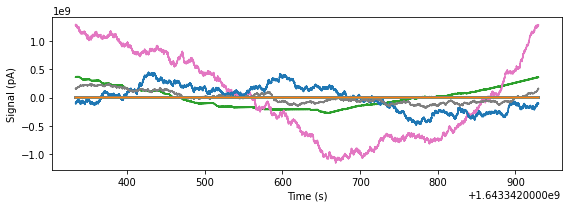

In [17]:
fig = plt.figure(figsize=(8,3))

for i in range(0,aman.dets.count,10):
    plt.plot( aman.timestamps, aman.signal[i] )
plt.ylabel('Signal (pA)')
plt.xlabel('Time (s)')

fig.tight_layout()

rfft: This function computes the one-dimensional n-point discrete Fourier Transform (DFT) of a real-valued array by means of an efficient algorithm called the Fast Fourier Transform (FFT).

In [18]:
ffts, freqs = rfft(aman, resize=None)

In [19]:
tsamp = np.median(np.diff(aman.timestamps))
norm_fact =  np.sqrt(2)*(1.0/tsamp)*np.sum(np.abs(np.hanning(aman.samps.count))**2)
##
fmsk = np.all([freqs > 11, freqs<20], axis=0)
det_white_noise = np.median(np.sqrt(np.abs(ffts[:,fmsk])**2/norm_fact), axis=1)

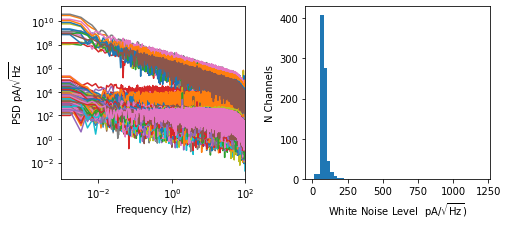

In [20]:
fig = plt.figure(figsize=(7,3.25))
plt.subplot(1,2,1)
for i in range(aman.dets.count):
    plt.loglog( freqs, np.sqrt(np.abs(ffts[i])**2/norm_fact) )
plt.ylabel('PSD $\mathrm{pA / \sqrt{Hz}}$')
plt.xlabel('Frequency (Hz)')
plt.xlim(None, np.max(freqs))
plt.subplot(1,2,2)
plt.hist(det_white_noise,bins=50, range=(10,1200))
plt.ylabel('N Channels');
plt.xlabel('White Noise Level  $\mathrm{pA / \sqrt{Hz}}$)')
fig.tight_layout()

## Filtering

In [21]:
my_special_filter = filters.high_pass_butter4(fc=4)*filters.low_pass_butter4(fc=12)
aman.wrap('filt_signal', filters.fourier_filter( aman, my_special_filter ) )

## If you want to replace signal you can do: aman.signal = filters.fourier_filter( aman, my_special_filter )

AxisManager(timestamps[samps], status*[filter_pars], signal[dets,samps], ch_info*[dets], primary*[samps], biases[bias_lines,samps], flags*[dets,samps], sig_mean[samps], pA_to_pW[dets], filt_signal[817,119232], dets:LabelAxis(817), samps:OffsetAxis(119232), filter_pars:IndexAxis(16), bias_lines:LabelAxis(16))

In [22]:
## specific to that one LATRt observation
good_channels = [236, 274, 364, 458,]
## 
good_idx = np.where( np.all([aman.ch_info.band == 3,
                             [ch in good_channels for ch in aman.ch_info.channel]], axis=0))[0]
print(good_idx)

[756]


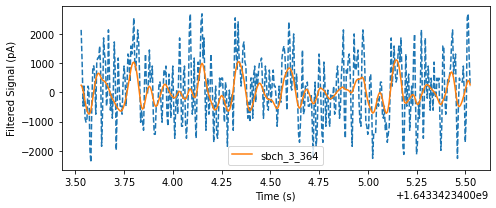

In [23]:
fig = plt.figure(figsize=(7,3))

tmsk = np.all( [aman.timestamps >= aman.timestamps[0]+10,
                aman.timestamps < aman.timestamps[0]+12], axis=0)
for i in good_idx:
    plt.plot( aman.timestamps[tmsk], aman.signal[i][tmsk],  ls='--' )
    plt.plot( aman.timestamps[tmsk], aman.filt_signal[i][tmsk], label=aman.dets.vals[i] )

plt.legend(ncol=2)
plt.ylabel( 'Filtered Signal (pA)' )
plt.xlabel( 'Time (s)' )
fig.tight_layout()

## Flagging and masking

In [24]:
from sotodlib.core import FlagManager
import sotodlib.flags as flags

In [25]:
aman.flags

FlagManager(dets:LabelAxis(817), samps:OffsetAxis(119232))

In [26]:
from so3g.proj import Ranges, RangesMatrix

In [27]:
t1_flag = Ranges(aman.samps.count, aman.samps.offset)
t1_flag.add_interval( 100,200)
print('T1: {}'.format(t1_flag.ranges()))
print('~T1: {}'.format((~t1_flag).ranges()))

t2_flag = Ranges(aman.samps.count,aman.samps.offset)
t2_flag.add_interval( 150,250)
print('T2: {}'.format(t2_flag.ranges()))

print('T1 + T2 = {}'.format( (t1_flag+t2_flag).ranges()))
print('T1 * T2 = {}'.format( (t1_flag*t2_flag).ranges()))

T1: [[100 200]]
~T1: [[     0    100]
 [   200 119232]]
T2: [[150 250]]
T1 + T2 = [[100 250]]
T1 * T2 = [[150 200]]


In [28]:
aman.flags.wrap( 'high_noise', det_white_noise > 1200)
aman.flags.wrap( 'low_noise', det_white_noise < 100)

In [29]:
aman.flags

FlagManager(high_noise[dets,samps], low_noise[dets,samps], dets:LabelAxis(817), samps:OffsetAxis(119232))

In [30]:
## Check which detectors have any cuts
aman.flags.has_cuts()
#aman.flags.reduce()[good_idx[0]].mask()

array(['sbch_0_000', 'sbch_0_007', 'sbch_0_010', 'sbch_0_011',
       'sbch_0_012', 'sbch_0_013', 'sbch_0_016', 'sbch_0_018',
       'sbch_0_019', 'sbch_0_023', 'sbch_0_024', 'sbch_0_026',
       'sbch_0_027', 'sbch_0_032', 'sbch_0_036', 'sbch_0_040',
       'sbch_0_043', 'sbch_0_048', 'sbch_0_056', 'sbch_0_058',
       'sbch_0_060', 'sbch_0_064', 'sbch_0_066', 'sbch_0_067',
       'sbch_0_072', 'sbch_0_082', 'sbch_0_084', 'sbch_0_093',
       'sbch_0_095', 'sbch_0_096', 'sbch_0_098', 'sbch_0_103',
       'sbch_0_106', 'sbch_0_114', 'sbch_0_117', 'sbch_0_119',
       'sbch_0_122', 'sbch_0_124', 'sbch_0_128', 'sbch_0_132',
       'sbch_0_136', 'sbch_0_138', 'sbch_0_141', 'sbch_0_146',
       'sbch_0_147', 'sbch_0_149', 'sbch_0_151', 'sbch_0_154',
       'sbch_0_164', 'sbch_0_168', 'sbch_0_171', 'sbch_0_175',
       'sbch_0_176', 'sbch_0_178', 'sbch_0_181', 'sbch_0_183',
       'sbch_0_184', 'sbch_0_186', 'sbch_0_189', 'sbch_0_192',
       'sbch_0_195', 'sbch_0_196', 'sbch_0_207', 'sbch_

In [31]:
## Check which channels are cut for high noise
aman.flags.has_cuts(flags=['high_noise'])

array(['sbch_0_007', 'sbch_0_010', 'sbch_0_018', 'sbch_0_229',
       'sbch_0_280', 'sbch_0_281', 'sbch_0_330', 'sbch_1_031',
       'sbch_1_127', 'sbch_1_319', 'sbch_1_364', 'sbch_1_419',
       'sbch_1_475', 'sbch_2_010', 'sbch_2_056', 'sbch_2_139',
       'sbch_2_269', 'sbch_2_362', 'sbch_2_409', 'sbch_3_124',
       'sbch_3_371', 'sbch_3_486'], dtype='<U10')

In [32]:
## Check which channels are cut for low noise
aman.flags.has_cuts(flags=['low_noise'])

array(['sbch_0_000', 'sbch_0_011', 'sbch_0_012', 'sbch_0_013',
       'sbch_0_016', 'sbch_0_019', 'sbch_0_023', 'sbch_0_024',
       'sbch_0_026', 'sbch_0_027', 'sbch_0_032', 'sbch_0_036',
       'sbch_0_040', 'sbch_0_043', 'sbch_0_048', 'sbch_0_056',
       'sbch_0_058', 'sbch_0_060', 'sbch_0_064', 'sbch_0_066',
       'sbch_0_067', 'sbch_0_072', 'sbch_0_082', 'sbch_0_084',
       'sbch_0_093', 'sbch_0_095', 'sbch_0_096', 'sbch_0_098',
       'sbch_0_103', 'sbch_0_106', 'sbch_0_114', 'sbch_0_117',
       'sbch_0_119', 'sbch_0_122', 'sbch_0_124', 'sbch_0_128',
       'sbch_0_132', 'sbch_0_136', 'sbch_0_138', 'sbch_0_141',
       'sbch_0_146', 'sbch_0_147', 'sbch_0_149', 'sbch_0_151',
       'sbch_0_154', 'sbch_0_164', 'sbch_0_168', 'sbch_0_171',
       'sbch_0_175', 'sbch_0_176', 'sbch_0_178', 'sbch_0_181',
       'sbch_0_183', 'sbch_0_184', 'sbch_0_186', 'sbch_0_189',
       'sbch_0_192', 'sbch_0_195', 'sbch_0_196', 'sbch_0_207',
       'sbch_0_208', 'sbch_0_210', 'sbch_0_212', 'sbch_